In [51]:
import random
import math
import matplotlib.pyplot as plt
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
import array
import numpy
import math


In [52]:
class Particle:
    def __init__(self, dimension, l_bound, h_bound):

        self.position = [random.uniform(l_bound, h_bound) for _ in range(dimension)]

        vmax = 0.1 * (h_bound - l_bound)
        self.velocity = [random.uniform(-vmax, vmax) for _ in range(dimension)]

        self.p_best = self.position.copy()
        self.g_best = None

        self.fitness = float('inf')
        self.b_fitness = float('inf')


    def calc_new_velocity(self, r1, r2, a_co1, a_co2, interia):

        cog_component = [r1 * a_co1 * (p - x) for p, x in zip(self.p_best, self.position)]

        soc_component = [r2 * a_co2 * (g - x) for g, x in zip(self.g_best, self.position)]

        vel_int = [interia * x for x in self.velocity]
    
        self.velocity = [v + c + s for v, c, s in zip(vel_int, cog_component, soc_component)]

    
    def calc_new_position(self, r1, r2, a_co1, a_co2, interia):

        self.calc_new_velocity(r1, r2, a_co1, a_co2, interia)

        self.position = [x + v for x, v in zip(self.position, self.velocity)]
        

In [53]:
def PSO(dimension, fitness, swarm_size, l_bound, h_bound, a_co1, a_co2, interia, max_iter=100, seed=100):

    rnd = random.Random(seed)
    swarm = [Particle(dimension, l_bound, h_bound) for _ in range(swarm_size)]

    best_fitnesses = []

    best_position = None
    best_fitness = float('inf')  # minimize fitness

    for _ in range(max_iter):
        for particle in swarm:
            particle.fitness = fitness(particle.position)

            # Update personal best
            if (particle.p_best is None) or (particle.fitness < particle.b_fitness):
                particle.p_best = particle.position.copy()
                particle.b_fitness = particle.fitness

            # Update global best
            if (best_position is None) or (particle.fitness < best_fitness):
                best_position = particle.position.copy()
                best_fitness = particle.fitness
            

        # Update velocities and positions
        for particle in swarm:
            particle.g_best = best_position.copy()
            r1 = rnd.random()
            r2 = rnd.random()
            particle.calc_new_position(r1, r2, a_co1, a_co2, interia)
        
        # Logs best fitness for logging
        best_fitnesses.append(best_fitness)

    return (best_position, best_fitness, best_fitnesses)


In [54]:
import array
import random
import numpy as np
from deap import base, creator, tools

def DE(dimension, fitness, swarm_size, l_bound, h_bound, F, CR, max_iter=100, seed=None):

    if seed is not None:
        random.seed(seed)       # Python random
        np.random.seed(seed) 

    # Avoid re-creating creator in the same session
    try:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    except:
        pass
    try:
        creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)
    except:
        pass

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, l_bound, h_bound)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, dimension)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("select", tools.selRandom, k=3)
    toolbox.register("evaluate", fitness)

    pop = toolbox.population(n=swarm_size)

    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # Evaluate initial population
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = (fit,)

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(pop), **record)
    print(logbook.stream)

    # Main DE loop
    for g in range(1, max_iter):
        for k, agent in enumerate(pop):
            # Select three distinct individuals
            a, b, c = toolbox.select(pop)
            y = toolbox.clone(agent)
            j_rand = random.randrange(dimension)
            for i in range(dimension):
                if i == j_rand or random.random() < CR:
                    y[i] = a[i] + F * (b[i] - c[i])
            # Evaluate trial vector
            y.fitness.values = (toolbox.evaluate(y),)
            # Selection: minimize
            if y.fitness.values[0] < agent.fitness.values[0]:
                pop[k] = y

        hof.update(pop)
        record = stats.compile(pop)
        logbook.record(gen=g, evals=len(pop), **record)
        print(logbook.stream)

    return logbook, hof


In [55]:
def rosenbrock_fitness(x):
    D = len(x)

    total = 0.0
    
    for i in range(D-1):
        total += 100 * (x[i]**2 - x[i+1])**2 + (x[i] - 1)**2
    return total

def griewank_fitness(x):

    sum_term = sum(xi**2 / 4000 for xi in x)

    prod_term = 1.0

    for i, xi in enumerate(x, start=1):
        prod_term *= math.cos(xi / math.sqrt(i))
    return sum_term - prod_term + 1


x_ros = np.ones(5)
print(f"Rosenbrock at (1,1,1,1,1): {rosenbrock_fitness(x_ros)}")

x_gri = np.zeros(5)
print(f"Griewank at (0,0,0,0,0): {griewank_fitness(x_gri)}")

Rosenbrock at (1,1,1,1,1): 0.0
Griewank at (0,0,0,0,0): 0.0


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def table_and_avg_plot(seed_res, title=""):

    final_bests = []
    all_best_values = []

    # --- Collect per-seed results ---
    for res in seed_res:
        seed = res['seed']
        best_values = res['best_values']
        final_bests.append(best_values[-1])
        all_best_values.append(best_values)

    # --- Average over seeds ---
    # Pad shorter runs with NaN if seeds have different lengths
    max_len = max(len(v) for v in all_best_values)
    arr = np.full((len(all_best_values), max_len), np.nan)
    for i, v in enumerate(all_best_values):
        arr[i, :len(v)] = v
    
    mean_over_gens = np.nanmean(arr, axis=0)
    std_over_gens = np.nanstd(arr, axis=0)

    # --- Plot only average curve ---
    plt.figure(figsize=(8,5))
    gens = np.arange(1, len(mean_over_gens)+1)
    plt.plot(gens, mean_over_gens, label="Mean Best Fitness")
    plt.fill_between(gens,
                     mean_over_gens - std_over_gens,
                     mean_over_gens + std_over_gens,
                     alpha=0.3, label="±1 Std Dev")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title(f"Average Best Fitness Across Seeds: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Create table with best individuals ---
    df = pd.DataFrame({
        'Seed': [res['seed'] for res in seed_res],
        'Best Individual': final_bests
    })

    # Append mean and std at the bottom
    summary_row = pd.DataFrame({
        'Seed': ['Mean', 'Std'],
        'Best Individual': [np.mean(final_bests), np.std(final_bests)]
    })

    final_table = pd.concat([df, summary_row], ignore_index=True)
    return final_table


In [57]:
def plot_fitness(fitnesses, title="Fitness Over Epochs"):
    plt.figure(figsize=(10, 6))
    plt.plot(fitnesses, label="Fitness")
    plt.xlabel("Epoch")
    plt.ylabel("Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

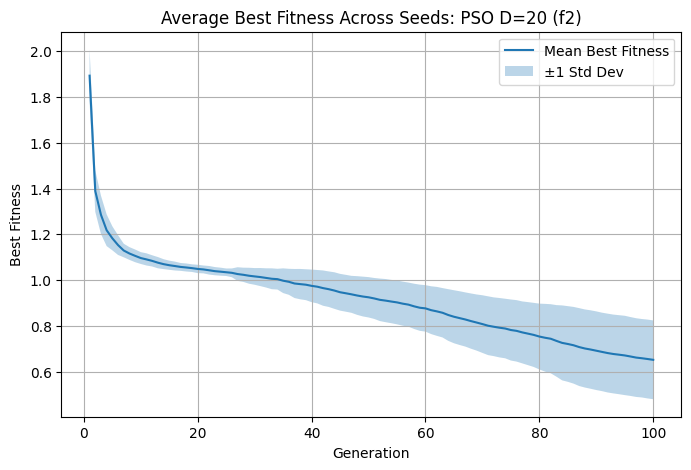

,Seed,Best Individual
0,100,0.586393
1,200,0.486741
2,300,0.894973
3,400,0.589185
4,500,0.694755
5,600,0.762555
6,700,0.481578
7,800,0.535074
8,900,0.546902
9,1000,0.521077


In [58]:
def run_seed_PSO(dimension,fitness):


    seeds = [i * 100 for i in range(1, 31)] 

    seed_res = []

    for seed in seeds:
        
        (best_position, best_fitness, best_fitnesses)  = PSO(dimension,fitness, 50, -30, 30, 1.5,1.5,0.8, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": best_fitnesses
        })

    return seed_res


seedd_res = run_seed_PSO(20, griewank_fitness)
table_and_avg_plot(seedd_res, title="PSO D=20 (f2)")


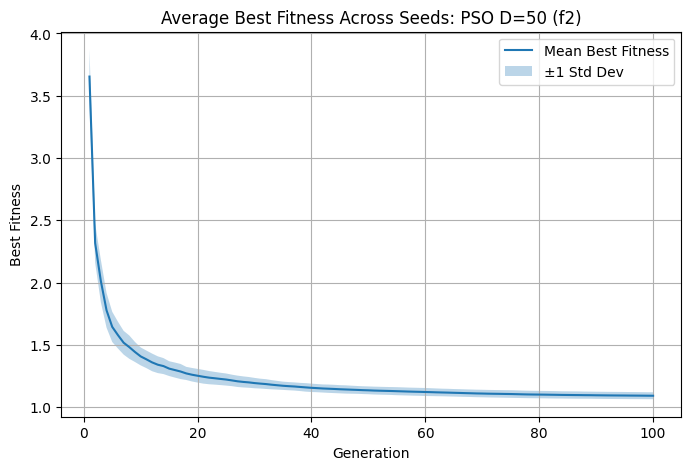

,Seed,Best Individual
0,100,1.122060
1,200,1.074295
2,300,1.081882
3,400,1.084273
4,500,1.116534
5,600,1.081242
6,700,1.103059
7,800,1.089855
8,900,1.109481
9,1000,1.194341


In [59]:
seedd_res = run_seed_PSO(50, griewank_fitness)
table_and_avg_plot(seedd_res, title="PSO D=50 (f2)")

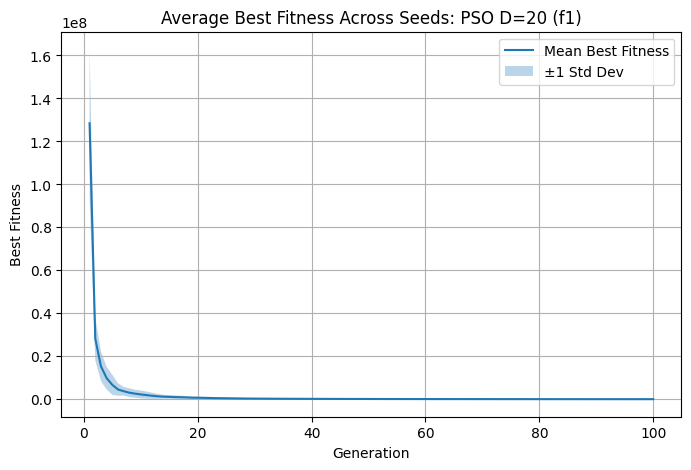

,Seed,Best Individual
0,100,5651.450919
1,200,96823.527683
2,300,14169.082140
3,400,4994.878068
4,500,13497.443205
5,600,16164.300118
6,700,29181.393420
7,800,62757.098322
8,900,4657.219884
9,1000,6071.701629


In [60]:
seedd_res = run_seed_PSO(20, rosenbrock_fitness)
table_and_avg_plot(seedd_res, title="PSO D=20 (f1)")

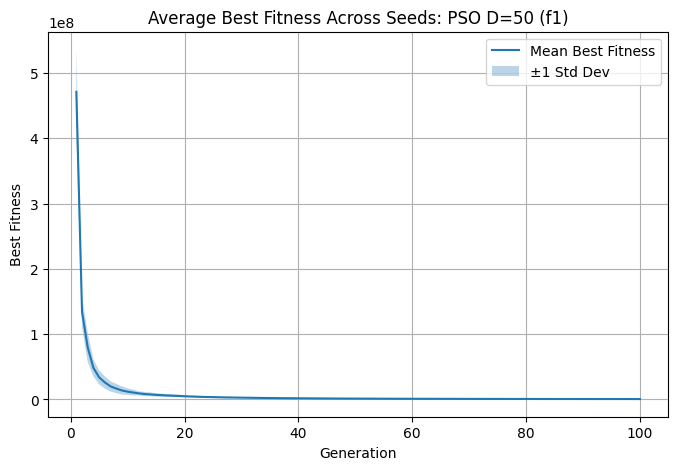

,Seed,Best Individual
0,100,7.143393e+05
1,200,1.201866e+06
2,300,7.523586e+05
3,400,6.289579e+05
4,500,3.483637e+05
5,600,3.996807e+05
6,700,7.637027e+05
7,800,6.216028e+05
8,900,6.511477e+05
9,1000,7.067329e+05


In [61]:

seedd_res = run_seed_PSO(50, rosenbrock_fitness)
table_and_avg_plot(seedd_res, title="PSO D=50 (f1)")

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	std     	min   	avg    	max    
0  	50   	0.293933	2.7664	3.25173	4.08383
1  	50   	0.27258 	2.7664	3.2204 	4.08383
2  	50   	0.288545	2.48057	3.17463	4.08383
3  	50   	0.278078	2.48057	3.14063	4.08383
4  	50   	0.286145	2.15738	3.08098	3.52333
5  	50   	0.308017	2.15738	3.05539	3.52333
6  	50   	0.328834	2.10738	3.0022 	3.52333
7  	50   	0.337958	2.10738	2.95563	3.52333
8  	50   	0.414404	1.73534	2.84361	3.37068
9  	50   	0.408503	1.73534	2.80499	3.37068
10 	50   	0.416084	1.73534	2.72472	3.37068
11 	50   	0.394522	1.73534	2.68616	3.37068
12 	50   	0.386154	1.73534	2.60599	3.37068
13 	50   	0.425139	1.71866	2.53411	3.37068
14 	50   	0.434884	1.71866	2.44175	3.37068
15 	50   	0.432141	1.71866	2.39644	3.37068
16 	50   	0.402384	1.71866	2.33532	3.37068
17 	50   	0.352017	1.62396	2.24615	3.05584
18 	50   	0.329173	1.58779	2.17726	2.90518
19 	50   	0.27348 	1.58779	2.11423	2.62695
20 	50   	0.263737	1.58214	2.07733	2.5518 
21 	50   	0.247839	1.58214	2.05005	2.54434
22 	50   	0.20

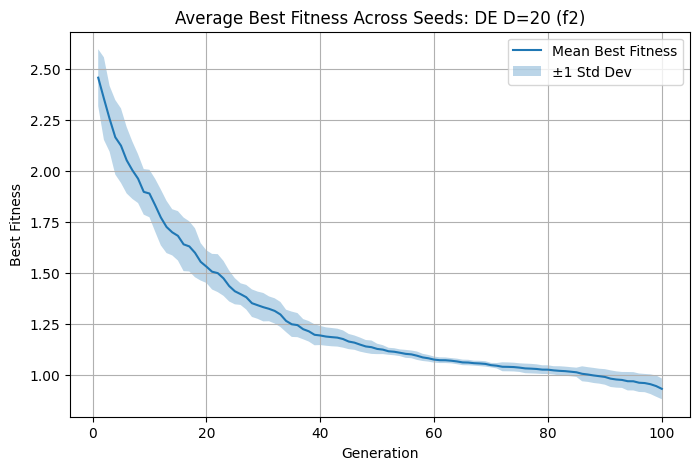

,Seed,Best Individual
0,100,0.963780
1,200,0.851180
2,300,0.887919
3,400,0.804042
4,500,0.904081
5,600,0.832868
6,700,0.968918
7,800,0.861593
8,900,0.994150
9,1000,0.921181


In [62]:
def run_seed_DE(dimension,fitness):

    seeds = [i * 100 for i in range(1, 31)] 

    seed_res = []

    for seed in seeds:
        
        (logbook,hfa) = DE(dimension,fitness, 50, -30, 30, 0.5,0.7, seed=seed)

        seed_res.append({
            "seed":seed,
            "best_values": logbook.select("min")
        })

    return seed_res


seedd_res = run_seed_DE(30, griewank_fitness)
table_and_avg_plot(seedd_res, "DE D=20 (f2)")



gen	evals	std     	min    	avg    	max    
0  	50   	0.431035	3.92656	4.74698	5.86246
1  	50   	0.468909	3.39365	4.72416	5.86246
2  	50   	0.543057	2.46205	4.66366	5.86246
3  	50   	0.547853	2.46205	4.62035	5.86246
4  	50   	0.595649	2.46205	4.54959	5.86246
5  	50   	0.633119	2.46205	4.479  	5.86246
6  	50   	0.754387	2.46205	4.33483	5.35407
7  	50   	0.737366	2.46205	4.28046	5.35407
8  	50   	0.752115	2.46205	4.15844	5.35407
9  	50   	0.714709	2.46205	4.02226	5.35407
10 	50   	0.713686	2.46205	3.93987	5.35407
11 	50   	0.72804 	2.46205	3.81644	5.17883
12 	50   	0.681275	2.46205	3.69175	4.92208
13 	50   	0.637016	2.46205	3.5942 	4.92208
14 	50   	0.621363	2.46205	3.55658	4.92208
15 	50   	0.581349	2.46205	3.44557	4.7839 
16 	50   	0.52647 	2.34201	3.32839	4.33052
17 	50   	0.513442	2.13588	3.22427	4.33052
18 	50   	0.486072	2.13588	3.16246	4.02162
19 	50   	0.478443	2.13588	3.09096	4.02162
20 	50   	0.419473	2.13588	3.01672	4.02162
21 	50   	0.426662	1.89768	2.92803	4.02162
22 	50   	0

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


99 	50   	0.0311894	1.07894	1.1488 	1.23168
gen	evals	std     	min    	avg    	max    
0  	50   	0.447485	3.76626	4.78745	5.68174
1  	50   	0.489202	3.32327	4.73166	5.68174
2  	50   	0.492167	3.32327	4.70349	5.68174
3  	50   	0.535486	3.32327	4.63556	5.55369
4  	50   	0.53032 	3.32327	4.54814	5.55369
5  	50   	0.533143	3.32327	4.48498	5.55369
6  	50   	0.551901	2.8273 	4.30559	5.32634
7  	50   	0.633902	2.68919	4.20155	5.27236
8  	50   	0.631223	2.68919	4.09063	5.27236
9  	50   	0.626612	2.68919	4.02089	5.27236
10 	50   	0.59659 	2.68919	3.95025	5.27081
11 	50   	0.590946	2.68919	3.8537 	5.27081
12 	50   	0.541261	2.68919	3.80127	4.72546
13 	50   	0.58608 	2.10076	3.72043	4.7185 
14 	50   	0.620341	2.10076	3.61141	4.66148
15 	50   	0.563289	2.10076	3.49723	4.54727
16 	50   	0.554797	2.10076	3.41725	4.49555
17 	50   	0.490382	2.10076	3.26925	4.28804
18 	50   	0.442687	2.10076	3.16003	4.28804
19 	50   	0.449839	2.10076	3.13467	4.28804
20 	50   	0.433222	2.10076	3.01345	4.06637
21 	50   	

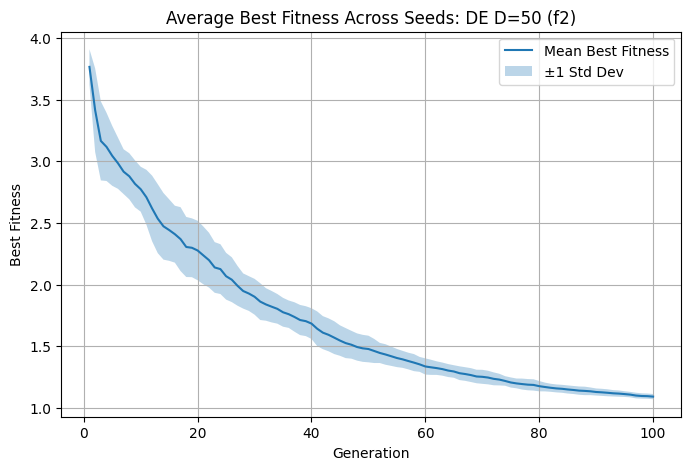

,Seed,Best Individual
0,100,1.078938
1,200,1.080770
2,300,1.094755
3,400,1.125966
4,500,1.091115
5,600,1.065697
6,700,1.081415
7,800,1.082087
8,900,1.103783
9,1000,1.101145


In [63]:

seedd_res = run_seed_DE(50, griewank_fitness)
table_and_avg_plot(seedd_res, "DE D=50 (f2)")

gen	evals	std        	min        	avg        	max        
0  	50   	8.51623e+07	1.48304e+08	3.12321e+08	5.24963e+08
1  	50   	9.22259e+07	1.48304e+08	2.97556e+08	5.24963e+08
2  	50   	9.01565e+07	1.37902e+08	2.85985e+08	5.24963e+08
3  	50   	9.13842e+07	6.81959e+07	2.61674e+08	5.24963e+08
4  	50   	9.20568e+07	6.81959e+07	2.48517e+08	5.24963e+08
5  	50   	8.24261e+07	6.81959e+07	2.28699e+08	5.24963e+08
6  	50   	6.89926e+07	4.07027e+07	1.97109e+08	3.3629e+08 
7  	50   	7.21967e+07	3.62416e+07	1.82328e+08	3.3629e+08 
8  	50   	7.21254e+07	3.62416e+07	1.66082e+08	3.3629e+08 
9  	50   	7.65686e+07	3.62416e+07	1.54242e+08	3.3629e+08 
10 	50   	6.36758e+07	3.62416e+07	1.21492e+08	2.64147e+08
11 	50   	5.3535e+07 	3.33055e+07	1.05432e+08	2.47311e+08
12 	50   	5.18328e+07	3.33055e+07	9.91299e+07	2.47311e+08
13 	50   	4.4221e+07 	3.33055e+07	8.88099e+07	2.31534e+08
14 	50   	3.94188e+07	1.76761e+07	8.13053e+07	1.88967e+08
15 	50   	3.46972e+07	1.69224e+07	7.62906e+07	1.81016e+08
16 	50   	2.71

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


5  	50   	9.52968e+07	4.88816e+07	2.1667e+08 	4.33095e+08
6  	50   	9.1877e+07 	4.88816e+07	2.02478e+08	4.33095e+08
7  	50   	7.89627e+07	4.88816e+07	1.85641e+08	4.157e+08  
8  	50   	7.92438e+07	4.88816e+07	1.80539e+08	4.157e+08  
9  	50   	7.82559e+07	4.88816e+07	1.73759e+08	4.157e+08  
10 	50   	7.17753e+07	4.88816e+07	1.58918e+08	3.81696e+08
11 	50   	6.54201e+07	4.88816e+07	1.45085e+08	2.97549e+08
12 	50   	6.63928e+07	4.88816e+07	1.38027e+08	2.84225e+08
13 	50   	6.30099e+07	1.32826e+07	1.23985e+08	2.84225e+08
14 	50   	5.33239e+07	1.32826e+07	1.12543e+08	2.63502e+08
15 	50   	5.00429e+07	1.32826e+07	1.00454e+08	2.63502e+08
16 	50   	4.25467e+07	1.32826e+07	8.92619e+07	1.98715e+08
17 	50   	4.02472e+07	1.32826e+07	8.13733e+07	1.78171e+08
18 	50   	3.62329e+07	1.32826e+07	7.34471e+07	1.75606e+08
19 	50   	3.28629e+07	1.32826e+07	6.92504e+07	1.4225e+08 
20 	50   	3.16287e+07	1.32826e+07	6.56188e+07	1.34144e+08
21 	50   	3.00102e+07	1.32826e+07	6.01216e+07	1.34144e+08
22 	50   	2.72

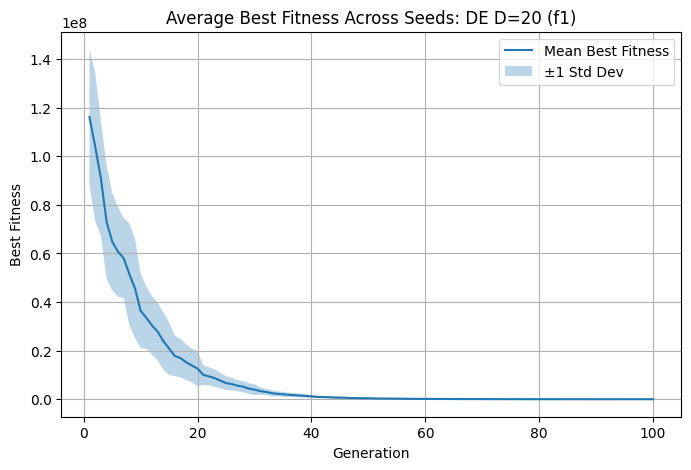

,Seed,Best Individual
0,100,9280.034888
1,200,5825.913928
2,300,2339.775188
3,400,1801.660827
4,500,3761.821832
5,600,2481.517231
6,700,2884.368427
7,800,3930.444091
8,900,4917.926003
9,1000,2553.802550


In [64]:
seedd_res = run_seed_DE(20, rosenbrock_fitness)
table_and_avg_plot(seedd_res, "DE D=20 (f1)")


gen	evals	std        	min        	avg        	max       
0  	50   	1.40127e+08	5.01783e+08	7.99041e+08	1.0994e+09
1  	50   	1.50067e+08	3.9258e+08 	7.93708e+08	1.0994e+09
2  	50   	1.70416e+08	1.79376e+08	7.84965e+08	1.0994e+09
3  	50   	1.71222e+08	1.79376e+08	7.80244e+08	1.0994e+09
4  	50   	1.82126e+08	1.79376e+08	7.69131e+08	1.0994e+09
5  	50   	1.83764e+08	1.79376e+08	7.66837e+08	1.0994e+09
6  	50   	2.26626e+08	1.79376e+08	7.28694e+08	1.0994e+09
7  	50   	2.26579e+08	1.79376e+08	7.20705e+08	1.0994e+09
8  	50   	2.42084e+08	1.79376e+08	6.89154e+08	1.06242e+09
9  	50   	2.42766e+08	1.79376e+08	6.58961e+08	1.06242e+09
10 	50   	2.47111e+08	1.79376e+08	6.47467e+08	1.06242e+09
11 	50   	2.46678e+08	1.79376e+08	6.21209e+08	1.06242e+09
12 	50   	2.32452e+08	1.79376e+08	5.92598e+08	1.06242e+09
13 	50   	2.27233e+08	1.79376e+08	5.81755e+08	1.06242e+09
14 	50   	2.26703e+08	1.79376e+08	5.70637e+08	1.06242e+09
15 	50   	2.16856e+08	1.79376e+08	5.33819e+08	1.06242e+09
16 	50   	2.21404e+08	1

/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/biboy/Desktop/school/AIML426/AIML426-Ass2/venv/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


76 	50   	5.64352e+06	8.06319e+06	2.00597e+07	3.14606e+07
77 	50   	5.68998e+06	8.06319e+06	1.93372e+07	3.14606e+07
78 	50   	5.41443e+06	8.06319e+06	1.84751e+07	3.14606e+07
79 	50   	5.21395e+06	8.06319e+06	1.79327e+07	3.14606e+07
80 	50   	4.8326e+06 	8.06319e+06	1.6754e+07 	2.63478e+07
81 	50   	5.00632e+06	6.44156e+06	1.61803e+07	2.63478e+07
82 	50   	5.26397e+06	4.02626e+06	1.48108e+07	2.63478e+07
83 	50   	4.92809e+06	4.02626e+06	1.39149e+07	2.62463e+07
84 	50   	4.5464e+06 	4.02626e+06	1.33762e+07	2.62463e+07
85 	50   	4.50276e+06	4.02626e+06	1.27441e+07	2.62463e+07
86 	50   	4.24233e+06	4.02626e+06	1.22964e+07	2.44691e+07
87 	50   	3.90174e+06	4.02626e+06	1.16327e+07	2.26657e+07
88 	50   	3.30387e+06	4.02626e+06	1.08604e+07	1.8983e+07 
89 	50   	3.4066e+06 	4.02626e+06	1.04264e+07	1.8983e+07 
90 	50   	3.11356e+06	4.02626e+06	9.89719e+06	1.73637e+07
91 	50   	3.28895e+06	4.02626e+06	9.48812e+06	1.73637e+07
92 	50   	3.36038e+06	4.02626e+06	9.18312e+06	1.73637e+07
93 	50   	3.24

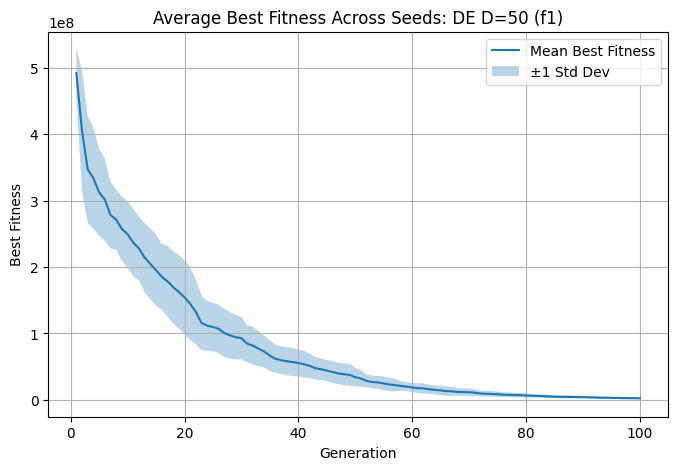

,Seed,Best Individual
0,100,1.711096e+06
1,200,1.496925e+06
2,300,2.592641e+06
3,400,2.211014e+06
4,500,1.650717e+06
5,600,2.461889e+06
6,700,1.433984e+06
7,800,3.434933e+06
8,900,3.782852e+06
9,1000,3.907850e+06


In [65]:
seedd_res = run_seed_DE(50, rosenbrock_fitness)
table_and_avg_plot(seedd_res, "DE D=50 (f1)")